In [1]:

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [2]:
def coregister_Seg_Dao_Pts(eclipse, band):
    
    segment_map, seg_sources = run_image_segmentation(eclipse, band)
        
    dao_pts, dao_extended, dao_crossreg, dao_summary = find_sources(eclipse, band)
    
    summary = {}
    
    sources_1 = seg_sources
    sources_2 = dao_crossreg
    
    # below and fun references are mostly michael's code from killscreen 
    mis_1, mis_2 = check_coregistration(sources_1, sources_2)
    sources = sources_1.loc[~mis_1].copy()
    sources2 = sources_2.loc[~mis_2].copy()
    
    summary["n_1"] = len(sources_1)
    summary["n_2"] = len(sources_2)
    summary["n_mismatch_1"] = len(np.nonzero(mis_1)[0])
    summary["n_mismatch_2"] = len(np.nonzero(mis_2)[0])
    summary["n_match"] = len(sources)
    sources["match"] = "both"
    sources2["match"] = "both"
    mis_1_sources = sources_1.loc[mis_1].copy()
    mis_1_sources["match"] = "seg"
    mis_2_sources = sources_2.loc[mis_2].copy()
    mis_2_sources["match"] = "dao"
    all_sources = pd.concat((sources, sources2, mis_1_sources, mis_2_sources))
    
    #daoInsideSeg_sources = check_DAOwithinSegLarge(seg_sources, dao_crossreg)
    
    return all_sources, summary, segment_map 

def run_image_segmentation(eclipse, band): 
    
    from photutils.segmentation import detect_sources
    from photutils.background import Background2D, MedianBackground
    from astropy.convolution import convolve
    from photutils.segmentation import make_2dgaussian_kernel
    from photutils.segmentation import SourceCatalog
    from photutils.segmentation import deblend_sources

    cnt_image = get_image_file(eclipse, band) # premasked

    bkg_estimator = MedianBackground()
    bkg = Background2D(cnt_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)
    cnt_image -= bkg.background  # subtract the background
    
    # define detection threshold (this is a 2D detection threshold
    # image made w/ background RMS image, 1.5 sigma per pixel 
    # noise level)

    threshold = 1.5 * bkg.background_rms

    kernel = make_2dgaussian_kernel(3, size=(3,3))# FWHM = 3.
    convolved_data = convolve(cnt_image, kernel)
    
    segment_map = detect_sources(convolved_data, threshold, npixels=3)


    segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=6, nlevels=20, contrast=0.001,
                               progress_bar=False)
    
    # use segmentation map to make catalog w morpholgoy info 
    cat = SourceCatalog(cnt_image, segm_deblend, convolved_data=convolved_data)
    columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux', 'elongation', 
               'eccentricity', 'equivalent_radius', 'orientation']
    seg_sources = cat.to_table(columns=columns).to_pandas()
    #seg_sources.rename(columns={"xcentroid": "a", "ycentroid": "c"}) # jk I think it's supposed to be xcentroid 
    
    return segment_map, seg_sources

def display_ptandextended_sources(eclipse, band):
    # really only meant to be used for visualizing while avoiding a whole pipeline run 
    grouped_point_sources, extended_sources, all_sources, summary  = find_sources(eclipse, band)
    
    plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')
    #plt.imshow(centile_clip(filtered))
    cmap = make_random_cmap(ncolors=5000,seed=23)

    for i, group in enumerate(grouped_point_sources.group_by('group_id').groups):
        for i2, point in enumerate(group):
            xypos = np.transpose([point['x_0'], point['y_0']])
            #print(xypos)
            ap = CircularAperture(xypos, r= (point['npix']/3.14)**.5) # using area of kernel to get radius, not same as fwhm
            #ap.plot(color=cmap.colors[point['npix']], lw=(point['sharpness']*2))
            ap.plot(color=cmap.colors[point['npix']], lw=.75)
            #ap.plot(color="red", lw=abs(point['sharpness']*2)+.25)

        
    # convex hull around extended sources
    #for hull in enumerate(extended_sources): 
    #    plt.plot(list(zip(*hull[1]))[0],list(zip(*hull[1]))[1],'w-',lw=1.2)
    
    plt.show()

def find_sources(eclipse, band):

    # temporary work arounds until part of real pipeline:
    # calculating exp time from exp time csv
    exptime = calc_exp_time(eclipse, band)

    print(f"The exposure time is: {exptime}")

    cnt_image = get_image_file(eclipse, band)

    # TODO: don't hardcode this, do we need this?
    #  _ exptime < 300:
    #     print("Skipping low exposure time visit.")
    #     Path(datapath, "LowExpt").touch()
    #     return "Skipping low exposure time visit."

    # 3 point source runs of DAOStarFinder
    small_point_sources = smallStarFinder(cnt_image, exptime)
    med_point_sources = mediumStarFinder(cnt_image, exptime)
    big_point_sources = bigStarFinder(cnt_image, exptime)
    bigger_point_sources = evenBiggerStarFinder(cnt_image, exptime)

    summary = {}
    
    sources_1 = small_point_sources
    sources_2 = med_point_sources
    
    # below and fun references are mostly michael's code from killscreen 
    mis_1, mis_2 = check_coregistration(sources_1, sources_2)
    sources = sources_1.loc[~mis_1].copy()
    summary["n_1"] = len(sources_1)
    summary["n_2"] = len(sources_2)
    summary["n_mismatch_1"] = len(np.nonzero(mis_1)[0])
    summary["n_mismatch_2"] = len(np.nonzero(mis_2)[0])
    summary["n_match"] = len(sources)
    sources["match"] = "both"
    mis_1_sources = sources_1.loc[mis_1].copy()
    mis_1_sources["match"] = "1"
    mis_2_sources = sources_2.loc[mis_2].copy()
    mis_2_sources["match"] = "2"
    all_sources = pd.concat((sources, mis_1_sources, mis_2_sources))
    
    # add FWHM kernel size info to each row of sources table so that we know which star finder 
    # run found which source / to plot them accurately 

    # combine small and big point sources
    combined_point_sources = pd.concat([small_point_sources, med_point_sources, big_point_sources,bigger_point_sources])

    # DBSCANGroup for collecting point sources into groups
    grouped_point_sources, extended_sources = extendedSourceFinder(combined_point_sources)

    try:
        print(f"Located {len(grouped_point_sources)} point sources and {len(extended_sources)} extended sources.")
    except TypeError:
        print(f"{eclipse} {band} contains no sources.")
        return None, None

    # was returning all sources instead of combined point sources before 
    return grouped_point_sources, extended_sources, combined_point_sources, summary 

def check_coregistration(ref, comp, threshold=2):
    c_cols = ['xcentroid', 'ycentroid']
    ref_xy = ref[c_cols].to_numpy()
    comp_xy = comp[c_cols].to_numpy()
    ref_offsets = coregister_sources(ref_xy, comp_xy)
    comp_offsets = coregister_sources(comp_xy, ref_xy)
    #print(type(comp_offsets))
    return (
        ref_offsets > threshold, comp_offsets > threshold
    )

def check_DAOwithinSegLarge(ref, comp):
    # ref = seg, comp = dao 
    c_cols = ['xcentroid', 'ycentroid']
    comp_xy = comp[c_cols].to_numpy()
    comp_offsets = []
    
    for i in len(ref): 
        threshold = ref["equivalent_radius"][i]
        ref_xy = ref[c_cols][i].to_numpy()
        added_inside_seg = coregister_sources(comp_xy, ref_xy)
        #added_inside_seg = 
        comp_offsets.append(added_inside_seg)
        
    return (
        comp_offsets < threshold
    )

def coregister_sources(xy0, xy1):
    matches = []
    for source_ix in range(xy0.shape[0]):
        vec = xy0[source_ix]
        vec = np.expand_dims(vec, 1).T
        offsets = np.linalg.norm(xy1 - vec, axis=1)
        matches.append(offsets.argmin())
    sort_xy1 = xy1[matches]
    return np.linalg.norm(sort_xy1 - xy0, axis=1)

def smallStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=4, sigma_radius=1.5, threshold=0.008, ratio=1, theta=0, sharplo=0.05)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def mediumStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=6, sigma_radius=1.5, threshold=0.008, ratio=.8, theta=45, sharplo=0.05)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def bigStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=8, sigma_radius=2, threshold=0.008, ratio=.9, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def evenBiggerStarFinder(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=20, sigma_radius=1.5, threshold=0.008, ratio=1, theta=0)
    source_table = daofind(cnt_image / exptime).to_pandas()
    return source_table

def extendedSourceFinder(positions):
    """uses combined pt source list to identify clumped groups
    of stars as extended sources"""
    from astropy.table import QTable, Table, Column
    from photutils.psf.groupstars import DBSCANGroup

    eps = 40 # dist value for grouping, very important

    starlist = Table()
    starlist['x_0'] = positions["xcentroid"]
    starlist['y_0'] = positions["ycentroid"]
    starlist['sharpness'] = positions["sharpness"]    
    starlist['roundness1'] = positions["roundness1"]
    starlist['roundness2'] = positions["roundness2"]
    starlist['npix'] = positions["npix"]
    starlist['peak'] = positions["peak"]
    starlist['flux'] = positions["flux"]
    
    dbscan_group = DBSCANGroup(crit_separation=eps)
    source_table_grouped = dbscan_group(starlist)
    
    dbsc_groups = source_table_grouped.group_by('group_id')
    # characterize morphology (fit ellipse, convex hull) of each group above a
    # certain cutoff in size
    extended_source_table = extendedSourceMorphology(dbsc_groups)

    return source_table_grouped, extended_source_table

def extendedSourceMorphology(dbsc_groups):
    """uses convex hull on collection of pts id'd as in the same group to show shape of extended source"""
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    extended_source_table = []
    for i, group in enumerate(dbsc_groups.groups):
        if len(group) > 10:
            xypos = np.transpose([group['x_0'], group['y_0']])
            hull = ConvexHull(xypos)
            # might not be the best way to do this, but want # of points in the complex hull
            # so making a list with tuples of the (# of points, [the hull simplices pairs])
            #extended_source_table.append(hull.simplices)
            extended_source_table.append(list(zip(xypos[hull.vertices,0], xypos[hull.vertices,1])))
    return extended_source_table

def calc_exp_time(eclipse, band):
    """sums frame exposure times in exp time csv output by pipeline """
    from os.path import exists
    if band == "FUV":
        b = "fd"
    else:
        b = "nd"
    if exists(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv"):
        exp_time = pd.read_csv(f"/home/bekah/glcat/exploration_notebooks/test_data/miniCat/e{eclipse}/e{eclipse}-{b}-30s-exptime.csv")
        tot_exp_time = sum(exp_time["expt"])
    return tot_exp_time

def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/exploration_notebooks/test_data/miniCat', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    # masking cnt image
    
    #print(cnt.shape)
    
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

# clipping 
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def see_convolved(pic,k_size): 
    from astropy.convolution import convolve
    from photutils.segmentation import (detect_sources,
                                    make_2dgaussian_kernel)
    
    kernel = make_2dgaussian_kernel(3.0, size=3)  # FWHM = 3.
    convolved_data = convolve(pic, kernel)
    return convolved_data

In [ ]:
get_image_file("02025", "NUV")

In [ ]:
%matplotlib notebook


eclipse = "02025"
band = "NUV"

all_sources, summary, segment_map = coregister_Seg_Dao_Pts(eclipse, band)
   
print(summary)
    
#plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),cmap='Greys_r',interpolation='none')
plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')

for index, point in all_sources.iterrows():
    
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])

    if point['match']=="both":
        method = "white"
        method_r = point['equivalent_radius']
        ap = CircularAperture(xypos, r=method_r)
        ap.plot(color=method, lw=.75)
    if point['match']=="dao":
        method = "orange"
        method_r = (point['npix']/3.14)**.5
        ap = CircularAperture(xypos, r=method_r)
        ap.plot(color=method, lw=.75)
    if point['match']=="seg":
        method = "black"
        method_r = point['equivalent_radius']
        ap = CircularAperture(xypos, r=method_r)
        ap.plot(color=method, lw=.75)
    
plt.show()



grouped_point_sources

In [ ]:
both_ided = all_sources[all_sources["match"] == 'both' ]
just_seg = all_sources[all_sources["match"] == 'seg' ]
just_dao = all_sources[all_sources["match"] == 'dao' ]

In [ ]:
len(both_ided)

In [ ]:
12408/3854

In [ ]:
plt.scatter(both_ided["segment_flux"],both_ided["area"],color='blue',alpha=0.5)
plt.scatter(both_ided["flux"],both_ided["npix"],color='purple',alpha=0.5)
plt.scatter(just_seg["segment_flux"],just_seg["area"],marker='+',color='red')
plt.scatter(just_dao["flux"],just_dao["npix"],marker='+',color='green')
plt.xlim(xmin=0,xmax=2500)
plt.ylim(ymax=2000)
plt.xlabel('seg flux')
plt.ylabel('area')

In [ ]:
plt.hist(both_ided["segment_flux"],range = (0,2000),alpha=0.5)
plt.hist(just_seg["segment_flux"],range = (0,2000),alpha=0.5,color="red")

In [93]:
def mask_for_extended_with_DBSCANGroup_TEMP(eclipse, band):

    # temporary work arounds until part of real pipeline:
    # calculating exp time from exp time csv
    exptime = calc_exp_time(eclipse, band)

    print(f"The exposure time is: {exptime}")

    cnt_image = get_image_file(eclipse, band)


    dao_sources = dao_for_grouping(cnt_image, exptime)

    extendedMask = extended_group_and_mask(dao_sources, cnt_image.shape) # image.shape is for mask shape 

    return extendedMask 

def dao_for_grouping(cnt_image, exptime):
    from photutils.detection import DAOStarFinder
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    daofind = DAOStarFinder(fwhm=5, sigma_radius=1.5, threshold=0.008, ratio=1, theta=0, sharplo=0.05)
    daofind2 = DAOStarFinder(fwhm=3, sigma_radius=2, threshold=0.02, ratio=.9, theta=0)

    source_table = daofind(cnt_image / exptime).to_pandas()
    source_table2 = daofind(cnt_image / exptime).to_pandas()
    dao_sources = pd.concat([source_table,source_table2])
    return dao_sources

def extended_group_and_mask(daoFinds, imageSize): 
    
    from photutils.psf.groupstars import DBSCANGroup
    from astropy.table import QTable, Table, Column 
    import numpy.ma as ma 

    positions = np.transpose((daoFinds['xcentroid'], daoFinds['ycentroid']))
    
    starlist = Table()

    x_0 = list(zip(*positions))[0]
    y_0 = list(zip(*positions))[1]

    starlist['x_0'] = x_0
    starlist['y_0'] = y_0

    fwhm_db = 8 # eps = 20

    dbscan_group = DBSCANGroup(crit_separation=2.5 * fwhm_db) 

    #dbsc_star_groups = dbscan_group(starlist).to_pandas().groupby(['group_id'])
    
    dbsc_star_groups = dbscan_group(starlist)

    dbsc_star_groups = dbsc_star_groups.group_by('group_id')
    
    mask = np.full(imageSize, False)
    
    for i, group in enumerate(dbsc_star_groups.groups):
        if len(group) > 60:
            newMask = get_hull_mask(group,imageSize)
            mask = ma.mask_or(mask,newMask)
        
    return mask
    
# using scipy convex hull & mpl path to get raster mask of convex hull 
#import pylab as plt
#import numpy as np

def get_hull_mask(group, imgShape ):
    
    from matplotlib.path import Path
    from scipy.spatial import ConvexHull, convex_hull_plot_2d

    #for i, group in enumerate(dbsc_star_groups.groups):
    #if len(group) > 20: 
    # use as filter before sending to this function
    xypos = np.transpose([group['x_0'], group['y_0']])
    hull = ConvexHull(xypos)

    hullVerts = tuple(zip(xypos[hull.vertices,0], xypos[hull.vertices,1]))
    #print(hullVerts)
    # image info (get from header?)
    ny, nx= imgShape # imgShape is a tuple 
    #width, height = imgShape
    
    # polygon takes data as: an array, masked array or sequence of pairs.
    
    # polygon = hullVerts # mb polygon should be in Path below? 
    poly_path=Path(hullVerts)

    #x, y = np.mgrid[:height, :width]
    #coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    #mask = poly_path.contains_points(coors)
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    grid = poly_path.contains_points(points)
    grid = grid.reshape((ny,nx))
    
    return grid
    
def imageSeg_withExtendedMask(eclipse, band):
    
    from photutils.segmentation import detect_sources
    from photutils.background import Background2D, MedianBackground
    from astropy.convolution import convolve
    from photutils.segmentation import make_2dgaussian_kernel
    from photutils.segmentation import SourceCatalog
    from photutils.segmentation import deblend_sources

    cnt_image = get_image_file(eclipse, band) # premasked
    
    exptime = calc_exp_time(eclipse, band)
    
    cnt_image = cnt_image / exptime # dividing by exposure time to normalize it across eclipses wrt exp time 

    bkg_estimator = MedianBackground()
    
    bkg = Background2D(cnt_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)
    
    cnt_image -= bkg.background  # subtract the background
    
    # define detection threshold (this is a 2D detection threshold
    # image made w/ background RMS image, 1.5 sigma per pixel 
    # noise level)

    threshold = 1.5 * bkg.background_rms

    kernel = make_2dgaussian_kernel(3, size=(3,3))# FWHM = 3.
    
    convolved_data = convolve(cnt_image, kernel)
    
    segment_map = detect_sources(convolved_data, threshold, npixels=5)


    segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=8, nlevels=20, contrast=0.004,
                               progress_bar=False)
    segm_deblend2 = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=20, contrast=0.008,
                               progress_bar=False)
    
    # use segmentation map to make catalog w morpholgoy info
    print("cnt image shp")
    print(cnt_image.shape)
    print("convolved shp")
    print(convolved_data.shape)

    columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux','elongation', 
               'eccentricity', 'equivalent_radius', 'orientation','max_value','maxval_xindex','maxval_yindex',
               'min_value','minval_xindex','minval_yindex','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax']
    
    
    # getting mask of extended sources w DAOfinder
    extendedMask = mask_for_extended_with_DBSCANGroup_TEMP(eclipse, band) # DAO one 
    
    # segmented grouping / masking 
    #cat = SourceCatalog(cnt_image, segm_deblend, convolved_data=convolved_data) # mask=extendedMask
    #seg_sources = cat.to_table(columns=columns).to_pandas()    
    
    #extendedMask = mask_from_seg_pts(seg_sources, cnt_image.shape) # cnt_image.shape for mask size/shape
    
    print("extended shp")
    print(extendedMask.shape)
    
    cat = SourceCatalog(cnt_image, segm_deblend, convolved_data=convolved_data, mask=extendedMask)
    
    seg_sources = cat.to_table(columns=columns).to_pandas()
                                     
    cat2 = SourceCatalog(cnt_image, segm_deblend2, convolved_data=convolved_data, mask=~extendedMask)
    
    extended_sources = cat2.to_table(columns=columns).to_pandas()
    
    return segm_deblend, seg_sources, extended_sources, extendedMask

def mask_from_seg_pts(segpts, imageSize): 
    
    from photutils.psf.groupstars import DBSCANGroup
    from astropy.table import QTable, Table, Column 
    import numpy.ma as ma 

    # try masking using max x, max y, min x, and min y from "bounding box"
    # should also get rid of the problem where the convex hull cuts the edge 
    # sources in half and they get ID'd twice 
    #centers = np.transpose((segpts['xcentroid'], segpts['ycentroid']))
    # bounding box corners for each seg 
    #bottomLeft = np.transpose((segpts['bbox_xmin'],segpts['bbox_ymin']))
    #topLeft = np.transpose((segpts['bbox_xmin'],segpts['bbox_ymax']))
    #bottomRight = np.transpose((segpts['bbox_xmax'],segpts['bbox_ymin']))
    #topRight = np.transpose((segpts['bbox_xmax'],segpts['bbox_ymax']))

    #print(positions)
    starlist = Table()

    x_0 = list(zip(*positions))[0]
    y_0 = list(zip(*positions))[1]

    #starlist['x_0'] = np.concatenate((segpts['ycentroid'],segpts['bbox_ymin'],
                                #     segpts['bbox_ymax'],segpts['bbox_ymin'],
                                #    segpts['bbox_ymax']),axis=None) #x_0
    #starlist['y_0'] = np.concatenate((segpts['xcentroid'],segpts['bbox_xmin'],
                                #     segpts['bbox_xmax'],segpts['bbox_xmin'],
                                #     segpts['bbox_xmax']),axis=None) #y_0

    fwhm_db = 8

    dbscan_group = DBSCANGroup(crit_separation=2.5 * fwhm_db)

    #dbsc_star_groups = dbscan_group(starlist).to_pandas().groupby(['group_id'])
    
    dbsc_star_groups = dbscan_group(starlist)

    dbsc_star_groups = dbsc_star_groups.group_by('group_id')
    
    mask = np.full(imageSize, False)
    
    for i, group in enumerate(dbsc_star_groups.groups):
        if len(group) > 300:
            newMask = get_hull_mask(group,imageSize)
            mask = ma.mask_or(mask,newMask)
        
    return mask

#def add_points_to_source(segpts): 
    # probably want to add points within 
    

cnt image shp
(3069, 3061)
convolved shp
(3069, 3061)
The exposure time is: 1358.2792409656265
extended shp
(3069, 3061)


<IPython.core.display.Javascript object>


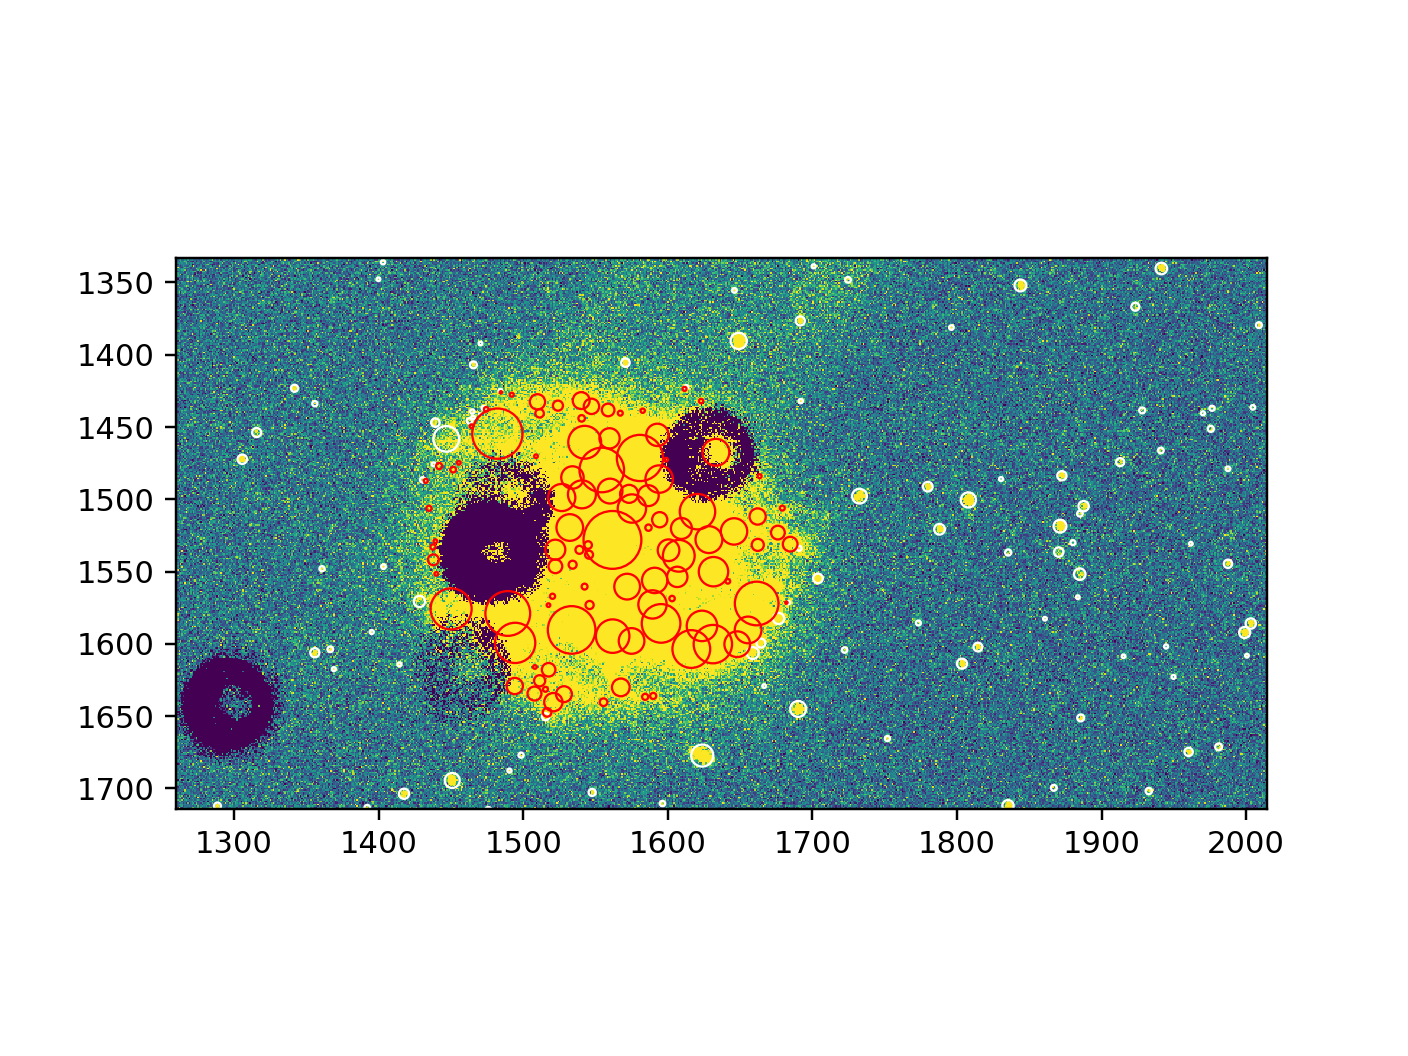

In [94]:
%matplotlib notebook

eclipse = "20920"
band = "NUV"
segment_map, seg_sources, ext_sources, mask = imageSeg_withExtendedMask(eclipse, band)


plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')

for index, point in seg_sources.dropna().iterrows():
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])
    method = "white"
    method_r = point['equivalent_radius']
    ap = CircularAperture(xypos, r=method_r)
    ap.plot(color=method, lw=.75)
    
for index, point in ext_sources.dropna().iterrows():
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])
    method = "red"
    method_r = point['equivalent_radius']
    ap = CircularAperture(xypos, r=method_r)
    ap.plot(color=method, lw=.75)

plt.show()

In [ ]:
# just extended source

pic = get_image_file(eclipse,band)

pic = np.where(mask,pic,0)

plt.imshow(centile_clip(pic,centiles=(0,90)),interpolation='none')

for index, point in ext_sources.dropna().iterrows():
    if point["area"] <300: 
        xypos = np.transpose([point['xcentroid'], point['ycentroid']])
        method = "red"
        method_r = point['equivalent_radius']
        ap = CircularAperture(xypos, r=method_r)
        ap.plot(color=method, lw=.75)



<IPython.core.display.Javascript object>


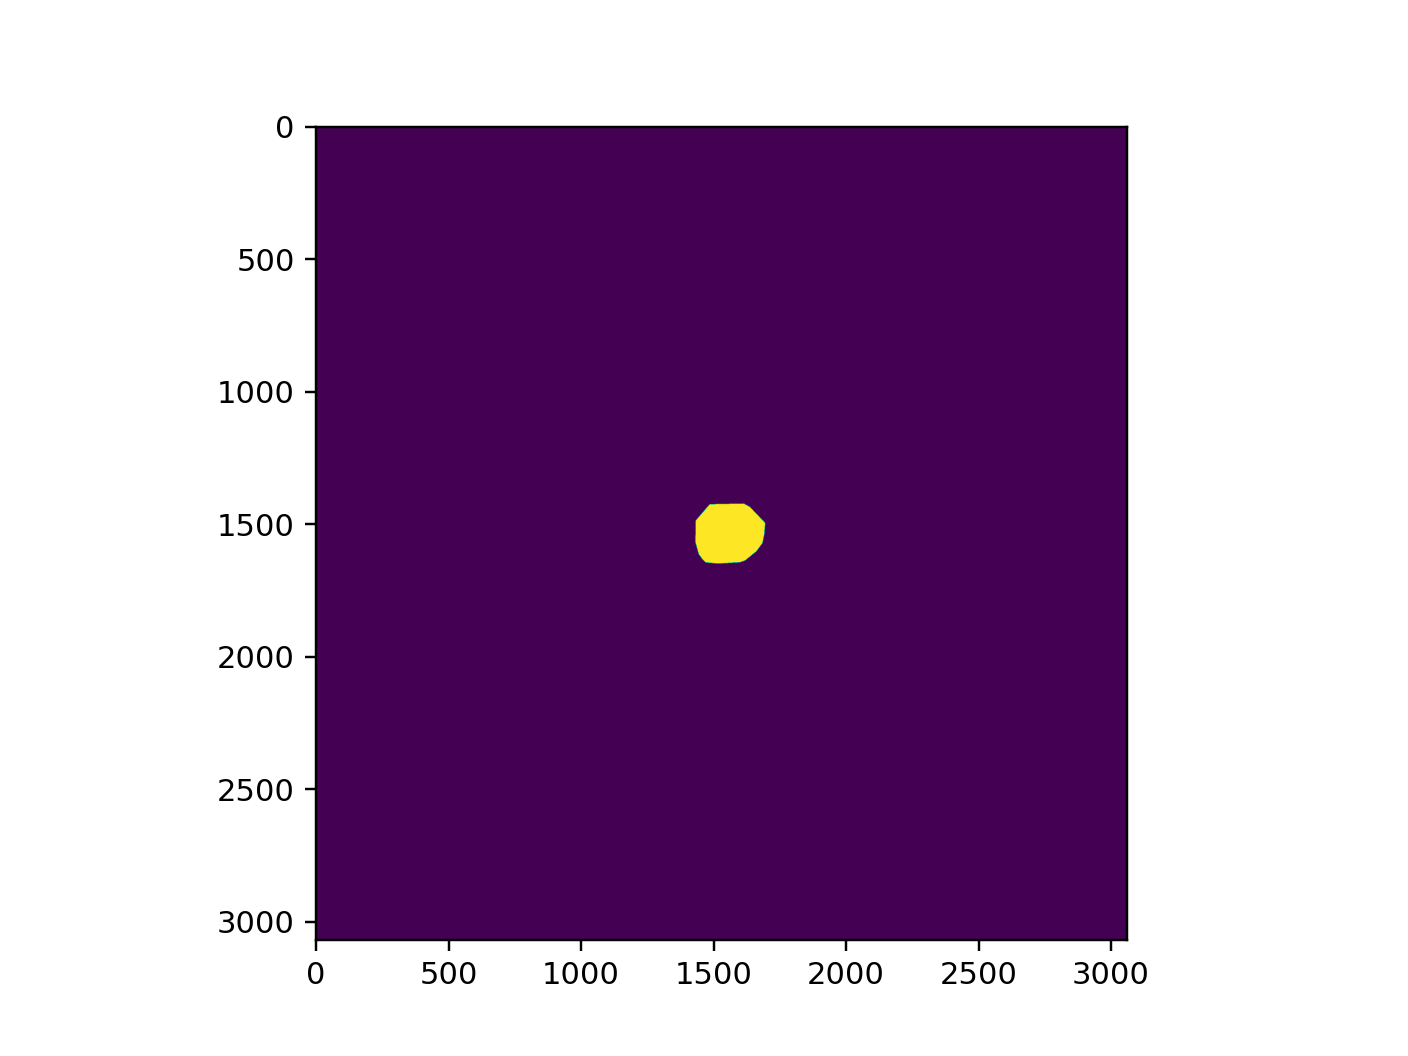

In [95]:
plt.imshow(mask)

## Rewrite to use extended source mask to label extended sources via segmentation image, not catalog 
#### this will save time? 1 less segmentation run / catalog run 

In [199]:
# imports to speed things up? 
from photutils.segmentation import detect_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import SourceCatalog
from photutils.segmentation import deblend_sources
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DBSCANGroup
from astropy.table import QTable, Table, Column 
import numpy.ma as ma 
from matplotlib.path import Path
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def run_source_extraction(eclipse, band):
    
    """exists because I'm not running this code in pipeline, so have to pull in premade images, cacl expt, etc."""
    
    cnt_image = get_image_file(eclipse, band) # premasked, in the normal pipeline you wouldn't need this 
    
    exptime = calc_exp_time(eclipse, band)
    
    print(f"The exposure time is: {exptime}")

    cnt_image_divExpt = cnt_image / exptime # dividing by exposure time to normalize it across eclipses wrt exp time 
    
    seg_sources, extended_sources, deblended_seg_map, extended_source_mask = get_sources(cnt_image_divExpt)
    
    return seg_sources, extended_sources, deblended_seg_map, extended_source_mask
    

def get_sources(cnt_image):
    
    # estimate and subtract the background
    bkg_estimator = MedianBackground()
    bkg = Background2D(cnt_image, (50, 50), filter_size=(3, 3),
                       bkg_estimator=bkg_estimator)
    cnt_image -= bkg.background 
    
    # define detection threshold (this is a 2D detection threshold
    # image made w/ background RMS image, 1.5 sigma per pixel 
    # noise level)
    threshold = 1.5 * bkg.background_rms

    # convolve the cnt image 
    kernel = make_2dgaussian_kernel(3, size=(3,3))# FWHM = 3.
    convolved_data = convolve(cnt_image, kernel)
    
    # segment image and deblend sources 
    segment_map = detect_sources(convolved_data,
                                 threshold,
                                 npixels=5)

    deblended_seg_map = deblend_sources(convolved_data,
                                       segment_map,
                                       npixels=8,
                                       nlevels=20,
                                       contrast=0.004,
                                       progress_bar=False)

    # use segmentation map to make catalog w morpholgoy info, columns are info we want in catalog
    # can add more columns w/ outputs listed in photutils image seg documentation
    columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux',
               'elongation','eccentricity', 'equivalent_radius', 'orientation',
               'max_value','maxval_xindex','maxval_yindex','min_value',
               'minval_xindex','minval_yindex','bbox_xmin','bbox_xmax',
               'bbox_ymin','bbox_ymax']
    
    
    # getting mask of extended sources w DAOfinder
    extended_source_mask = mask_for_extended_sources(cnt_image) # <- !PROB WANT TO CHANGE THIS TO NON BGND SUBTRACTED!
    
    #extended_sources = ma.array(deblended_seg_map, mask=extended_source_mask)
    #extended_sources = np.unique(deblended_seg_map[extended_source_mask])

    extended_sources = np.unique(deblended_seg_map*extended_source_mask)[1:]
    print(extended_sources)
    cat = SourceCatalog(cnt_image, 
                        deblended_seg_map, 
                        convolved_data=convolved_data)
    
    seg_sources = cat.to_table(columns=columns).to_pandas()

    seg_sources = seg_sources.set_index(seg_sources["label"])
    
    print(seg_sources)
    
    # this cannot be the best way to do this?
    seg_sources["extended_source"] = False 
    #for i in extended_sources: 
    #    seg_sources.loc["label"]==i]["extended_source"] = True
    #seg_sources.iloc[extended_sources]["extended_source"] = True 
    seg_sources.loc[extended_sources,"extended_source"] = True 
    
    return seg_sources, extended_sources, deblended_seg_map, extended_source_mask


def mask_for_extended_sources(cnt_image):

    dao_sources = dao_finder(cnt_image)

                                         # image.shape is for mask shape
    extended_mask = get_extended_mask(dao_sources, cnt_image.shape)  

    return extended_mask 

def dao_finder(cnt_image):
    # DAO Star Finder Arguments:
    # fwhm = full width half maximum of gaussian kernel
    # threshold = pixel value below which not to select a source
    # ratio = how round kernel is (1 = circle)
    # theta = angle of kernel wrt to x-axis in degrees
    
    # currently combining two DAO runs, could probably do one 
    daofind = DAOStarFinder(fwhm=5, 
                            sigma_radius=1.5,
                            threshold=0.008,
                            ratio=1,
                            theta=0,
                            sharplo=0.05)
    
    daofind2 = DAOStarFinder(fwhm=3,
                             sigma_radius=2,
                             threshold=0.02,
                             ratio=.9,
                             theta=0)

    source_table = daofind(cnt_image).to_pandas()
    source_table2 = daofind(cnt_image).to_pandas()
    
    dao_sources = pd.concat([source_table,source_table2])
    
    return dao_sources

def get_extended_mask(dao_sources, imageSize): 
    

    positions = np.transpose((dao_sources['xcentroid'], dao_sources['ycentroid']))
    
    starlist = Table()

    x_0 = list(zip(*positions))[0]
    y_0 = list(zip(*positions))[1]

    starlist['x_0'] = x_0
    starlist['y_0'] = y_0

    fwhm_db = 8 # therefore critical separation = 20

    # grouping based on distance between points 
    dbscan_group = DBSCANGroup(crit_separation=2.5 * fwhm_db) 
    dbsc_star_groups = dbscan_group(starlist)
    dbsc_star_groups = dbsc_star_groups.group_by('group_id')
    
    mask = np.full(imageSize, 0) # used to be boolean, False
    
    gID = 1
    for i, group in enumerate(dbsc_star_groups.groups):
        if len(group) > 60:
            newMask = get_hull_mask(group, gID, imageSize)
            #mask = ma.mask_or(mask,newMask) # combine masks
            mask = np.add(mask,newMask) 
            #gID += 1 
            
    return mask
    

def get_hull_mask(group, groupID, imageSize):
    
    """calculates convex hull of pts in group and uses Path to make a mask of 
    each convex hull, assigning a number to each hull as they are made"""
    xypos = np.transpose([group['x_0'], group['y_0']])
    hull = ConvexHull(xypos)

    hullVerts = tuple(zip(xypos[hull.vertices,0], xypos[hull.vertices,1]))

    ny, nx= imageSize # imageSize is a tuple of width, height
    
    # path takes data as: an array, masked array or sequence of pairs.
    poly_path=Path(hullVerts)

    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    hull_mask = poly_path.contains_points(points,radius=1.0) # radius adds a small buffer area to the mask
    hull_mask = hull_mask.reshape((ny,nx))
    hull_mask = hull_mask.astype(int)*groupID
    
    return hull_mask

In [200]:

%matplotlib notebook

eclipse = "08556"
band = "NUV"
seg_sources, extended_sources, deblended_seg_map, extended_source_mask = run_source_extraction(eclipse, band)


plt.imshow(centile_clip(get_image_file(eclipse,band),centiles=(0,99)),interpolation='none')

for index, point in seg_sources.dropna().iterrows():
    xypos = np.transpose([point['xcentroid'], point['ycentroid']])
    if point["extended_source"] is False: 
        method = "white"
    elif point["extended_source"] is True: 
        method = 'red'
    method_r = point['equivalent_radius']
    ap = CircularAperture(xypos, r=method_r)
    ap.plot(color=method, lw=.75)

plt.show()

The exposure time is: 1432.4232767469346
[ 1912  1922  1923 ... 11914 11916 11918]
       label    xcentroid    ycentroid  area  segment_flux  elongation  \
label                                                                    
1          1  1575.000304   130.769077   7.0      0.001156    1.059661   
2          2  1221.524737   175.465884  31.0      0.003817    1.403783   
3          3  1234.257758   173.638403   5.0      0.001125    1.685666   
4          4  1226.922251   174.566496   6.0      0.000690    1.526559   
5          5  1873.060471   174.543137   6.0      0.000649    1.526216   
...      ...          ...          ...   ...           ...         ...   
6672    6672  1538.535211  2974.114682  17.0      0.001995    1.431725   
6673    6673  1534.461424  2977.351822  26.0      0.003120    1.930996   
6674    6674  1529.193056  2977.848193  11.0      0.001493    1.416818   
6675    6675  1487.145502  2975.552004  14.0      0.002075    1.701388   
6676    6676  1490.938213  29

KeyError: '[11912, 11914, 11916, 11918] not in index'

<IPython.core.display.Javascript object>


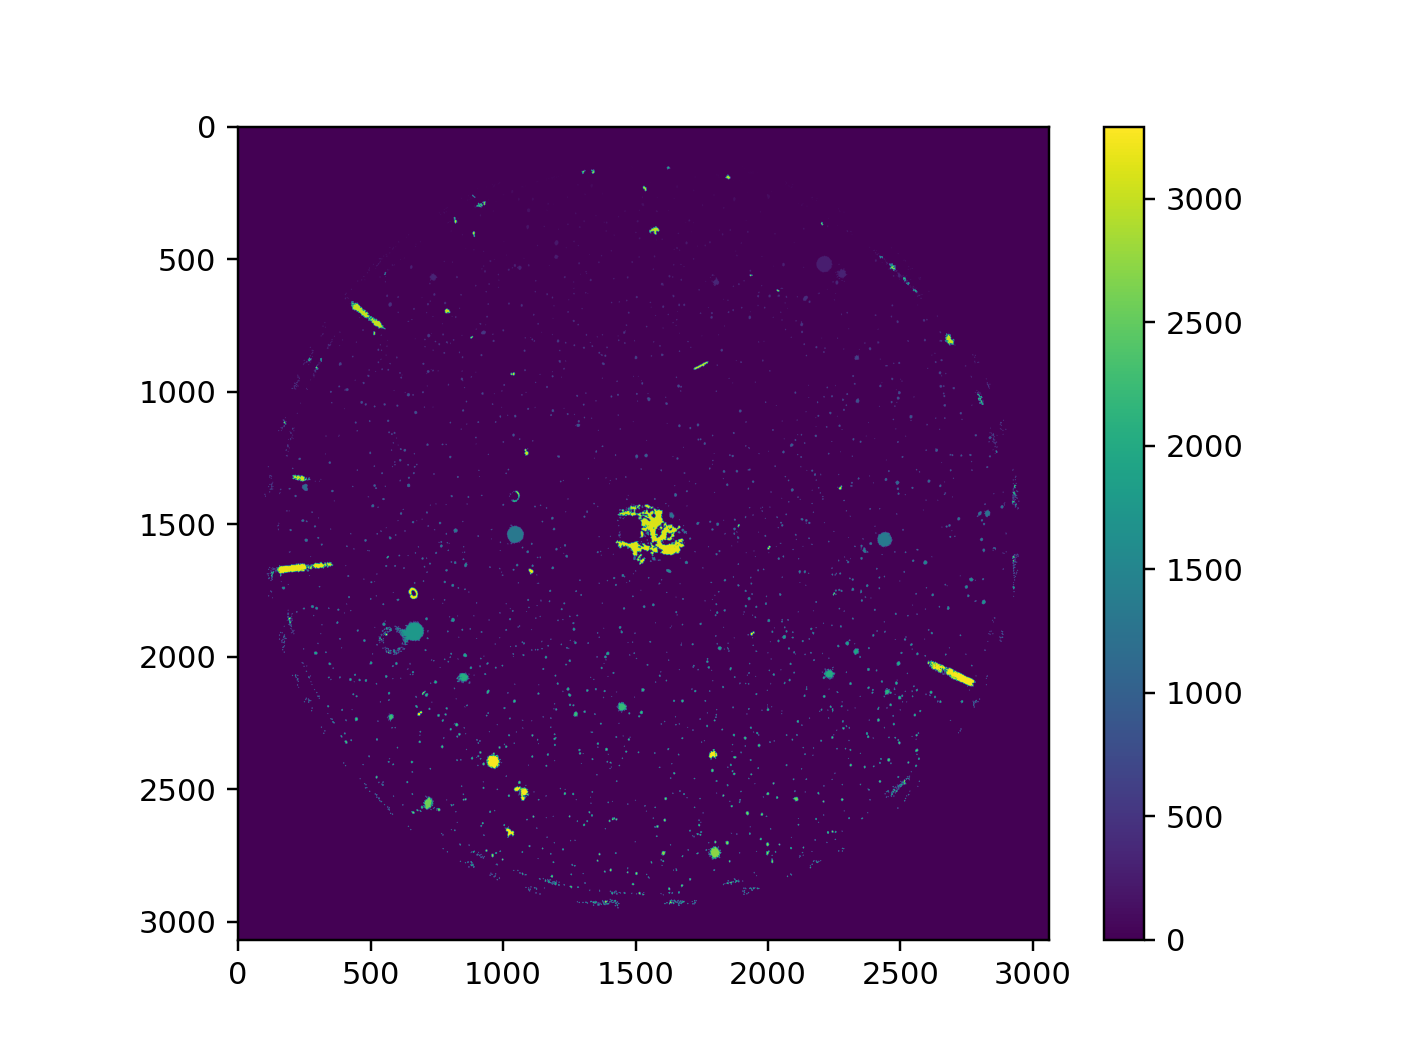

In [201]:
plt.imshow(deblended_seg_map)
plt.colorbar()

In [169]:
type(seg_sources)

pandas.core.frame.DataFrame

In [198]:
extended_sources

array([1218, 1222, 1227, 1232, 1233, 1240, 1242, 1247, 1251, 1252, 1268,
       1274, 1278, 1281, 1282, 1285, 1291, 1294, 1316, 1317, 1332, 1334,
       1341, 1343, 1344, 1348, 1349, 1357, 1360, 1371, 1375, 1381, 1384,
       1386, 1392, 1393, 1396, 1454, 1463, 1468, 1478, 1481, 1482, 1486,
       3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097,
       3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108,
       3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119,
       3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130,
       3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141,
       3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152,
       3153, 3154, 3155, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3167,
       3168, 3169, 3170, 3171, 3172, 3173, 3174])